# Data Exploratory Notebook

In this notebook we will try to dig deeply into the Smartphone Log data obtained from Cambridge. The data that we use is supposed to be previously parsed and with the following format:

| **timestamp** | **phone_features** | **battery_level** |

where *timestamp* involves minutes (accumulative and daily), and day (accumulative and weekly); *battery_level* is the mobile phone's battery level for that row; and *phone_features* includes the following features:

• Battery plugged: whether the mobile is or is not plugged to a charger, regardless the type of charger (USB, put the rest). Type: binary. 

• Bright level: screen’s bright level. Type: binary. 

• Screen on: whether the mobile’s screen was on or off. Type: binary. 

• Conn: this feature informs if the smartphone is connected to a 3G network. Type: binary. 

• Conn wifi: similar to the previous one, but in this case it is for WIFI networks. Type: binary. 

• Temperature: indicates the temperature of the mobile's battery. Type: continuous. 

• Voltage: indicates the battery’s voltage. Type: continuous.

Basically the analysis is separated in three main parts: univariate analysis, bi-variate analysis and multivariate analysis. For each of them we will focus on all the features and the relationship between them so that we can use the resulting information in our Machine Learning models.

Let's start by importing all the required libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

Now we will define some useful constants.

In [2]:
columns = [u'milliseconds', u'day', u'min', u'battery_level', u'battery_plugged',
       u'bright_level', u'screen_on', u'conn', u'conn_wifi', u'temperature',
       u'voltage', u'battery_level_grouped', u'battery_common_smooth',
       u'battery_exp_smooth', u'no_day', u'relative_day', u'relative_min']

path_dataset = '../preprocessed/preprocessed_user1.csv'

Once everything is set we can load the dataset into a Pandas DataFrame.

In [3]:
df_dataset = pd.read_csv(path_dataset, names=columns)
df_dataset.head(10)

,milliseconds,day,min,battery_level,battery_plugged,bright_level,screen_on,conn,conn_wifi,temperature,voltage,battery_level_grouped,battery_common_smooth,battery_exp_smooth,no_day,relative_day,relative_min
0,128378483.0,2.0,1102.0,4.0,0.0,149.0,0.0,0.0,1.0,305.0,3646.0,0.0,4.0,4.0,0.0,0.765278,1102.0
1,128378483.0,2.0,1103.0,4.0,0.0,149.0,0.0,0.0,1.0,305.0,3646.0,0.0,4.0,4.0,0.0,0.765972,1103.0
2,128378483.0,2.0,1104.0,4.0,0.0,149.0,0.0,0.0,1.0,305.0,3646.0,0.0,4.0,4.0,0.0,0.766667,1104.0
3,128378483.0,2.0,1105.0,4.0,0.0,149.0,0.0,0.0,1.0,305.0,3646.0,0.0,4.0,4.0,0.0,0.767361,1105.0
4,128678505.0,2.0,1106.0,4.0,0.0,149.0,0.0,0.0,1.0,280.0,3647.0,0.0,4.0,4.0,0.0,0.768056,1106.0
5,128678505.0,2.0,1107.0,4.0,0.0,149.0,0.0,0.0,1.0,280.0,3647.0,0.0,4.0,4.0,0.0,0.768750,1107.0
6,128678505.0,2.0,1108.0,4.0,0.0,149.0,0.0,0.0,1.0,280.0,3647.0,0.0,4.0,4.0,0.0,0.769444,1108.0
7,128678505.0,2.0,1109.0,4.0,0.0,149.0,0.0,0.0,1.0,280.0,3647.0,0.0,4.0,4.0,0.0,0.770139,1109.0
8,128678505.0,2.0,1110.0,4.0,0.0,149.0,0.0,0.0,1.0,280.0,3647.0,0.0,4.0,4.0,0.0,0.770833,1110.0
9,128978495.0,2.0,1111.0,4.0,0.0,149.0,0.0,0.0,1.0,265.0,3646.0,0.0,4.0,4.0,0.0,0.771528,1111.0


Before we start with the analysis, let's just take a look at an extract of data points of our target feature *battery_level*. It is very important to mention that the data is continuous in the sense that each value heavily depends on the previous one.

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


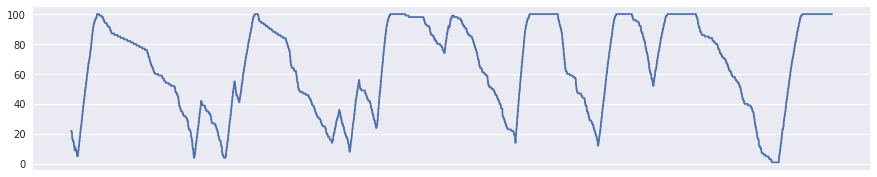

In [4]:
plt.figure(figsize=(15, 3))
plt.plot(df_dataset['battery_level'][10000: 18000])
plt.xticks([])
plt.show()

The resulting curve is not uniform, it takes different shapes, and it doesn't have a preset behaviour. However, we can see that it somewhat resembles a sinusoidal curve, since it continuously goes up and down, that is something very important that we will describe later. We can also point out that the curve rarely touches the zero level, while on the opposite when it gets the 100 level, it can be left charging and hence its level keeps the same for a while. Finally, we can see that the curve has some noise, it isn't completely fluid but stepped, we will see how to deal with this problem as well.

Let's get hands dirty!

## Univariate Analysis

According to Wipipedia: "**Univariate analysis** is the simplest form of analyzing data. “Uni” means “one”, so in other words your data has only one variable. It doesn't deal with causes or relationships (unlike regression) and it's major purpose is to describe; it takes data, summarizes that data and finds patterns in the data."

That's basically what we are going to do now. We are going to depict all the descriptors possible for only one variable, i.e., mean, std, quartiles, max, min, and mode. We are only going to pick some of the features, the ones that originally comes with the dataset, so that it can be better understood. Specifically, we will use: the battery level, battery plugged, conn, conn wifi, voltage, temperature, screen on, bright level, hour and day.

In [5]:
features = "min day battery_plugged conn conn_wifi bright_level screen_on voltage temperature battery_level".split()

mode = df_dataset[features].astype(int).mode()
mode.index=['mode']
df_dataset[features].describe().append(mode).round(2)

,min,day,battery_plugged,conn,conn_wifi,bright_level,screen_on,voltage,temperature,battery_level
count,633621.00,633621.00,633621.00,633621.00,633621.00,633621.00,633621.00,633621.00,633621.00,633621.00
mean,720.25,3.00,0.35,0.24,0.72,196.81,0.31,3915.05,252.76,61.50
std,415.70,2.01,0.48,0.43,0.45,59.14,0.46,217.13,64.46,31.38
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3105.00,-33.00,0.00
25%,360.00,1.00,0.00,0.00,0.00,149.00,0.00,3771.00,206.00,36.00
50%,720.00,3.00,0.00,0.00,1.00,192.00,0.00,3924.00,252.00,65.00
75%,1080.00,5.00,1.00,0.00,1.00,255.00,1.00,4118.00,298.00,92.00
max,1440.00,7.00,2.00,1.00,1.00,255.00,1.00,4231.00,604.00,100.00
mode,384.00,0.00,0.00,0.00,1.00,149.00,0.00,4165.00,250.00,100.00


The statistics are not greatly meaningful, it can be seen that there is a wide variability for all the sensors and all lay in the range that was stated. There is a slight skew in some features, e.g., it can be inferred that the screen is most of the time turned off, that the mobile phone is usually connected to a wifi network but not to 3G. A curious fact is that despite being most of the time unplugged from a charger, the smartphone's level of battery is mostly on its level 100. It may be because when the charger is connected, it is left plugged although the battery has been fully charged.

## Bivariate Analysis

Bi-variate analysis takes into account pairs of features so that we can "measure" the relationship between those two variables. More formally, **Bivariate analysis** is the simultaneous analysis of two variables (attributes). It explores the concept of relationship between two variables, whether there exists an association and the strength of this association, or whether there are differences between two variables and the significance of these differences. 

Let's start by the simplest relationship, but not less important, between battery level and time. We will plot the curve for each day of the week so that we can figure out if there is a deviation between the different days.

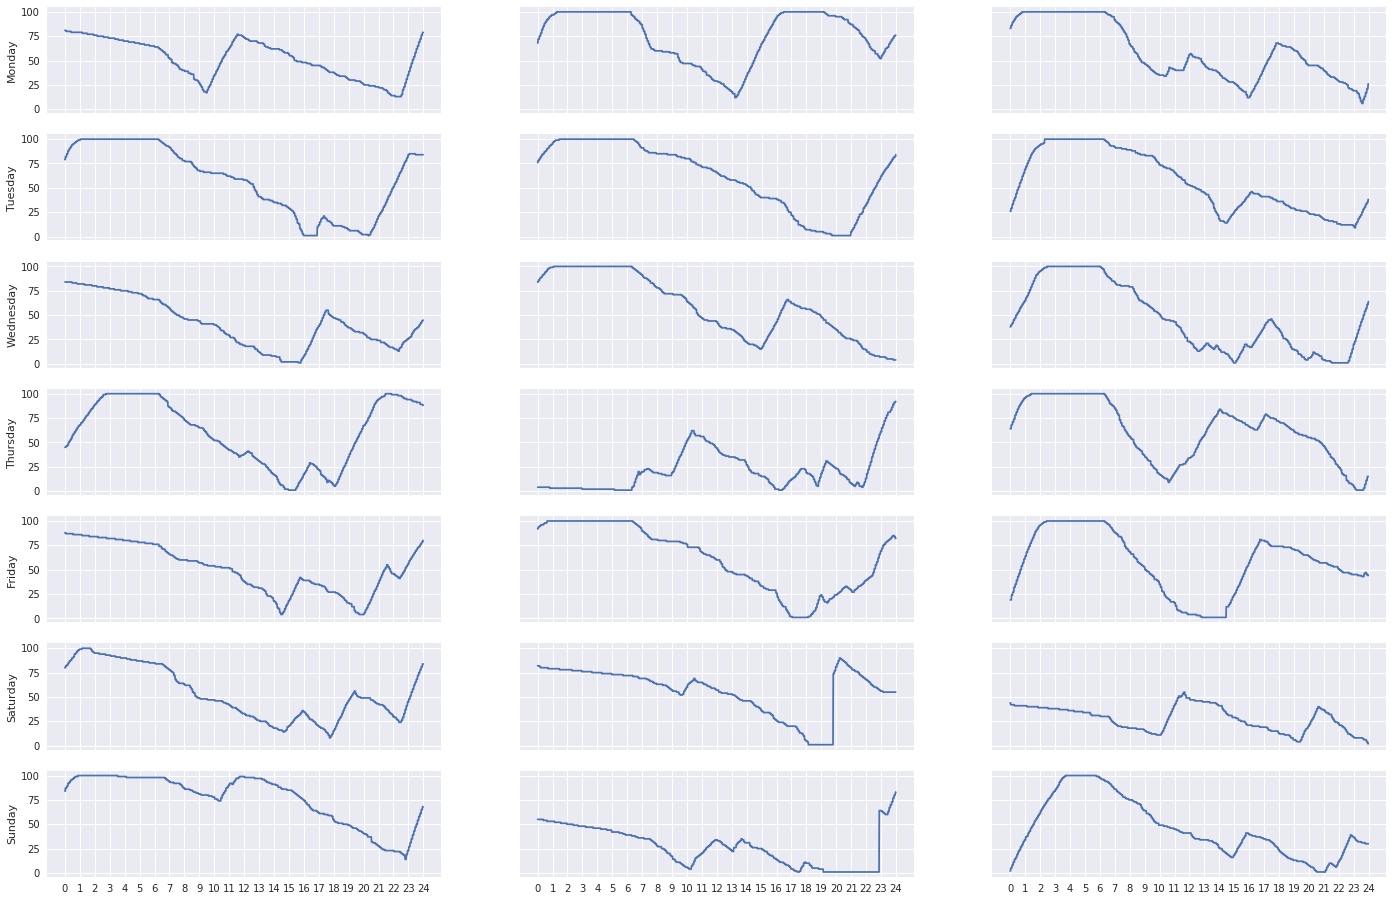

In [6]:
days = 'Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split()
init = df_dataset[df_dataset['day'] == 0].index[0]
mins_per_day = 24 * 60
f, ax = plt.subplots(7, 3, sharey=True, sharex=True, figsize=(24, 16))

for week in range(3):
    for i in range(7):
        from_ = init + i * mins_per_day
        to_ = from_ + mins_per_day
        ax[i, week].plot(range(mins_per_day), df_dataset[from_:to_]['battery_level'])
        if week == 0:
            ax[i, week].set_ylabel(days[i])
    init = init + mins_per_day * 7

plt.xticks(range(0, mins_per_day + 1, 60), range(25)) 
plt.show()


The charts show a very interesting relationship. The user tends to plug the charger at night and maybe in the mid-afternoon. (S)He usually does not pay so much attention to the mobile phone on weekends since the level of battery tend to be constantly low, especially on Sunday week 2.

Let's see what is the average battery level for each hour of the day, for each day.

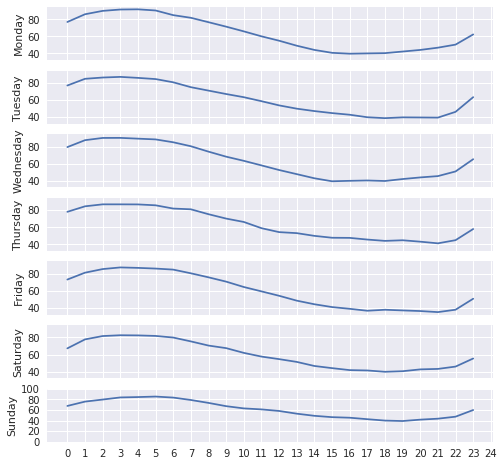

In [7]:
days = 'Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split()
df_dataset['hour'] = map(int, df_dataset['min'] / 60)
aux = df_dataset[['day', 'hour', 'battery_level']].groupby(['day', 'hour']).mean().reset_index()
f, ax = plt.subplots(7, 1, sharey=True, sharex=True, figsize=(8, 8))

for d in range(7):
    ax[d].plot(range(24), aux[aux['day'] == d].sort_values('hour')['battery_level'][:-1])
    ax[d].set_yticks(range(0, 101, 20))
    ax[d].set_ylabel(days[d])

plt.xticks(range(25))
plt.show()

Nice! all the curves look very similar, and all of them have a very sinusoidal resemblance. This can be pivotal, with this information we can add a brand new set of features: *sinus* and *cosinus*. Since the cycle almost always start at the beginning of the day and ends at the end of it, we should fill both functions as follows:

* amplitude * sin(2 * pi * mins / mins_per_day) + battery_level_mean

Sinus cycle starts at zero and ends after **2 \* pi**. Here we need to start at the beginning of the day, i.e., **min = 0**. Finally, we need to go forward progressively, and that's why we use the ratio **mins / mins_per_day**. We add the battery level's mean in order to center the curve. The amplitude tells how much the curve should go up and down, which is bounded by the range [0-100]. In the same way we will also add the cosinus just in case the curve doesn't start at the beginnig of the day.

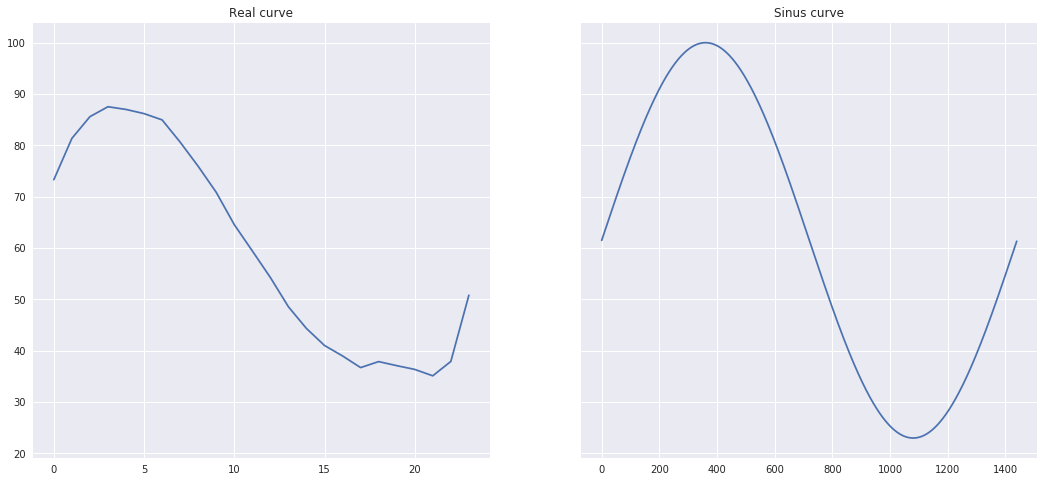

In [8]:
init = df_dataset[df_dataset['min'] == 0].index[0]
mins_per_day = 60 * 24
battery_level_mean = df_dataset['battery_level'].mean()
amplitude = min(100 - battery_level_mean, battery_level_mean - 0)

mins = df_dataset['min'][init:init+mins_per_day]
sins = np.sin(np.pi * 2 * df_dataset['min'] / mins_per_day) * amplitude + battery_level_mean
cos = np.cos(np.pi * 2 * df_dataset['min'] / mins_per_day) * amplitude + battery_level_mean
df_dataset['sin'] = sins
df_dataset['cos'] = cos

# Let's plot it to compare
f, ax = plt.subplots(1, 2, sharey=True, sharex=False, figsize=(18, 8))

# We are going to first plot the real values from day 4
aux = df_dataset[['day', 'hour', 'battery_level']].groupby(['day', 'hour']).mean().reset_index()
ax[0].plot(range(24), aux[aux['day'] == 4].sort_values('hour')['battery_level'][:-1])
ax[0].set_title('Real curve')

# Now we are going to plot the sinus curve
ax[1].plot(mins, sins[init:init+mins_per_day])
ax[1].set_title('Sinus curve')

plt.show()

Great resemblance! It's worth pointing out that we are getting a curve that is very similar to the real one, and we are just using the minute of the day as input! That is really powerful.

Now let's take a closer look at the battery level along the time.

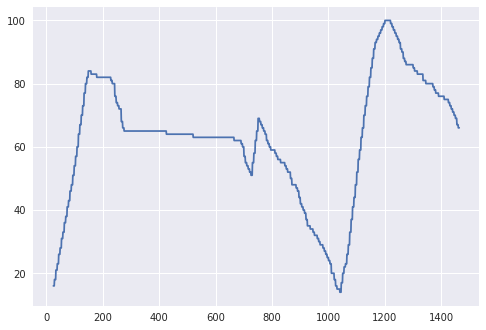

In [9]:
plt.plot(range(25,1465), df_dataset['battery_level'][50:1490])
plt.show()

It's noticeable that the curve is not fluid, rather it is noisy with very small steps. That noise might also affect the Machine Learning algorithms we'll use. So let's make it smoother by using a simple averaging smoothness over 50 steps.

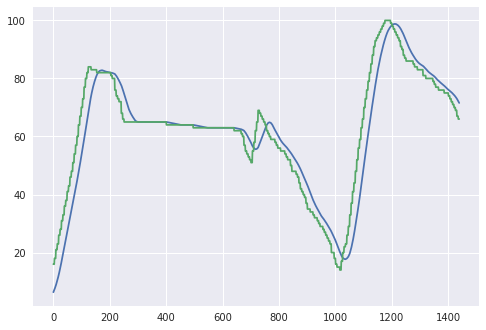

In [10]:
n = 50
battery_levels = df_dataset['battery_level'][:-n]
for i in range(1, n):
    battery_levels = battery_levels.add(df_dataset['battery_level'][i:-n+i].values)

plt.plot(range(1440), battery_levels.divide(n)[:1440])
plt.plot(range(1440), df_dataset['battery_level'][n:1440+n])
plt.show()

We left an offset so that it's easy to see the difference. The blue line, which is the smoothed one, looks perfectly continuous, highlighting the steps of the original curve. We will add it to our dataset for later analysis.

In [11]:
n = 50
smoothed = df_dataset['battery_level'][:n/2].append(battery_levels.divide(n).append(df_dataset['battery_level'][-n/2:]))
df_dataset['battery_level_smoothed'] = list(smoothed)

Now we are going to move on, and see the correlation between features, either positive or negative. In addition, we will highlight those that have a strong relationship. Finally, we will include the original set of features and we will also add the sinus that we recently obtained.

In [12]:
features = "min day battery_plugged conn conn_wifi bright_level screen_on voltage temperature sin cos battery_level".split()

corr = np.corrcoef(df_dataset[features], rowvar=0)
corr_df = pd.DataFrame(corr, columns=features, index=features)
corr_df.style.applymap(lambda val: 'color: red' if abs(val) > .4 else 'color: black')

A fancy way to chart all this information is by using the hinton chart, where red indicates a positive correlation, while a blue a negative one.

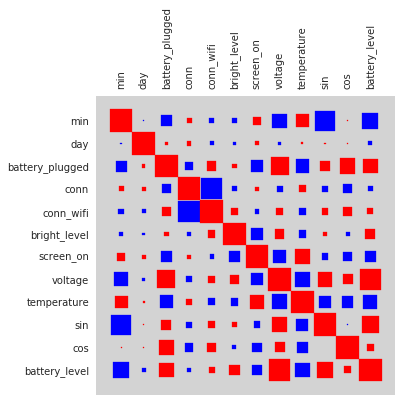

In [13]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))

    ax.patch.set_facecolor('lightgray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'red' if w > 0 else 'blue'
        size = np.sqrt(np.abs(w))
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    nticks = matrix.shape[0]
    ax.xaxis.tick_top()
    ax.set_xticks(range(nticks))
    ax.set_xticklabels(list(matrix.columns), rotation=90)
    ax.set_yticks(range(nticks))
    ax.set_yticklabels(matrix.columns)
    ax.grid(False)

    ax.autoscale_view()
    ax.invert_yaxis()
    plt.show()

hinton(corr_df)

Well there are so many relationships that are worth poiting out. First we can see the very strong relationship between the sinus that we recently added and the battery level, which means that the feature augmentation was successful. Besides, we can see that there is a much stronger positive correlation between the voltage and the battery level, what makes a lot of sense because the voltage is a factor to calculate the level of battery.

Let's plot these two variables along with the battery plugged feature altogether in order to be able to see the relationship.

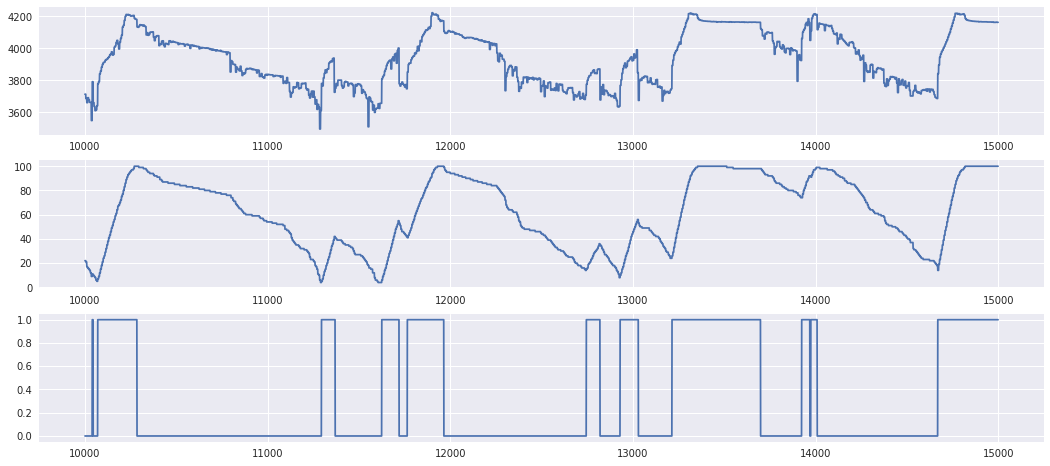

In [14]:
f, ax = plt.subplots(3, 1, figsize=(18, 8))
ax[0].plot(df_dataset['voltage'][10000:15000])
ax[1].plot(df_dataset['battery_level'][10000:15000])
ax[2].plot(df_dataset['battery_plugged'][10000:15000])
plt.show()

It's clear that the first two curves look very similar, that's why the relationship between them is so strong. If you know the voltage you almost know the battery level. Despite the fact that this sounds great, it is bad news because it will overfit the model and it will be useless for predictions in the future. That is, knowing what's the volage in the future is as difficult as to know what's the level of battery, so if we use the voltage to train the model then the model will strongly rely on the voltage, but we won't be able to supply that information for future predictions what will lead to a poor performance. So for now let's just forget the feature *voltage*.

On the other hand, although expectable, it's interesting to note that whenever the battery is plugged its level of battery increase. Furthermore, estimating whether the mobile phone will be plugged to a charger is not that difficult, it has some relationship with the time of the day (*min*). This very last point is something to bear in mind while building the Machine Learning algorithm.

Interestingly, when the smartphone is connected to WIFI it isn't connected to 3G and viceversa, that is what the very negative correlation between them tells us. Let's show this relationship in a chart.

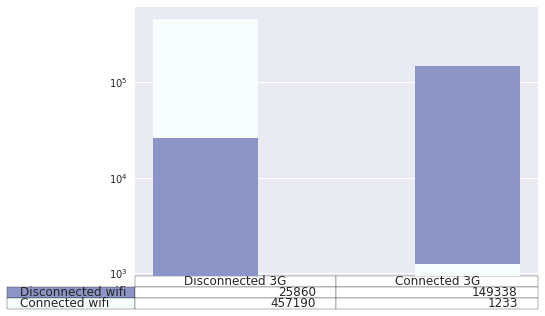

In [15]:
aux2 = df_dataset[['conn_wifi', 'conn', 'min']].groupby(['conn_wifi', 'conn']).count().reset_index()
pivot = aux2.pivot_table(index='conn_wifi', columns='conn', values='min')
pivot = np.array(pivot)

colors = plt.cm.BuPu(np.linspace(0, 0.5, len(pivot)))
colors = colors[::-1]
n_rows = len(pivot)
columns = ['Disconnected 3G', 'Connected 3G']
rows = ['Disconnected wifi', 'Connected wifi']

index = np.arange(len(columns)) + 0.3
bar_width = 0.4


# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.array([0.0] * len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    plt.bar(index, pivot[row], bar_width, color=colors[row])
plt.bar(index[0], pivot[0][0], bar_width, color=colors[0])
plt.yscale('log')
plt.table(cellText=np.array(pivot),rowLabels=rows,
                      rowColours=colors, colLabels=columns, loc='bottom')


plt.subplots_adjust(left=0.2, bottom=0.2)
plt.xticks([])
plt.show()

In the chart above we can see that when the wifi is connected the 3G signal is disconected and viceversa. They rarely have the same value.

Something very important to point out is the strong correlation between the time in minutes and the sinusoidal approximation of the battery level. This would make sense when we think that the time was used to carry out the sinus, but the cosinus is also carried out as a factor of the time and it doesn't hold any relationship. Thus, the sinus, as well as the battery level, is very influenced by the time. What is something expectable if we look at the charts that were depicted previously.

Much more interesting is the relationship between the cosinus and the battery plugged feature. It seems that whenever the cosinus is high (especially at night) the mobile phone is connected. This is extremely important because by only knowing the time of the event that we want to predict we can estimate the sinus and cosinus and use such values to estimate the level of battery and if it is plugged or not, respectively. However, the cosinus was calculated thinking in much higher amplitude, we should rescale it to the *battery plugged* range. Let's plot it to see its influence.

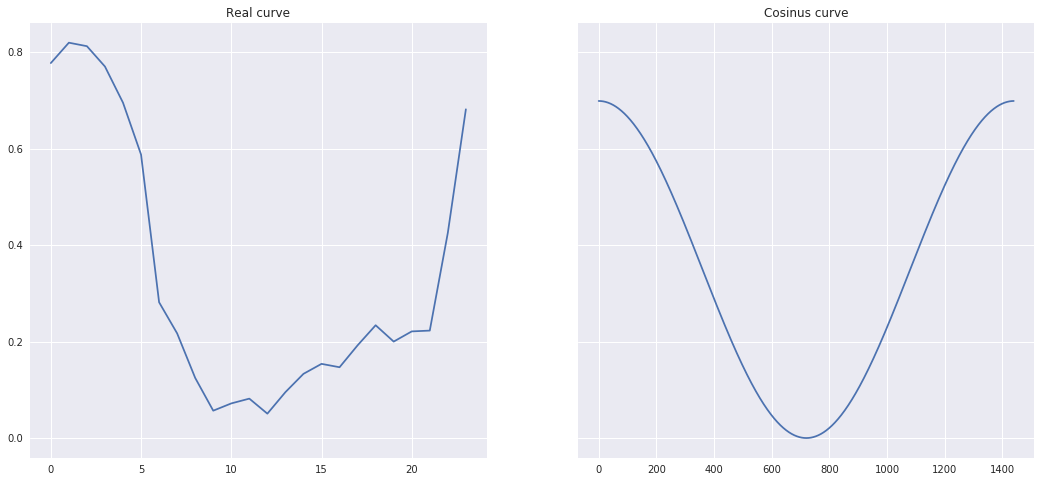

In [16]:
init = df_dataset[df_dataset['min'] == 0].index[0]
mins_per_day = 60 * 24
battery_plugged_mean = df_dataset['battery_plugged'].mean()
amplitude = min(1 - battery_plugged_mean, battery_plugged_mean - 0)

mins = df_dataset['min'][init:init+mins_per_day]
cos_plugged = np.cos(np.pi * 2 * df_dataset['min'] / mins_per_day) * amplitude + battery_plugged_mean
df_dataset['cos_plugged'] = cos_plugged

# Let's plot it to compare
f, ax = plt.subplots(1, 2, sharey=True, sharex=False, figsize=(18, 8))

# We are going to first plot the real values from day 4
aux = df_dataset[['day', 'hour', 'battery_plugged']].groupby(['day', 'hour']).mean().reset_index()
ax[0].plot(range(24), aux[aux['day'] == 4].sort_values('hour')['battery_plugged'][:-1])
ax[0].set_title('Real curve')

# Now we are going to plot the sinus curve
ax[1].plot(mins, cos_plugged[init:init+mins_per_day])
ax[1].set_title('Cosinus curve')

plt.show()

Great results, they truly resemble each other. We are going to recalculate the correlation between them now that they have the same scale.

In [17]:
features = "battery_plugged cos_plugged".split()

corr = np.corrcoef(df_dataset[features], rowvar=0)
corr_df = pd.DataFrame(corr, columns=features, index=features)
corr_df.style.applymap(lambda val: 'color: red' if abs(val) > .4 else 'color: black')

Not surprisingly, the correlation remains. This is because the relationship is the same, whenever one feature goes up, the other one does the same. Nevertheless, the scale is now the same, and it will have much more influence in the predictions.

## Univariate Time Series Analysis

It can be noticed that the battery level is continuous curve along the time, where the value at time **n+1** is greatly influenced by the value at time **n**. We can think this problem as a time series situation, where our series is the battery level along the time.

As the name suggests, Time Series (TS) is a collection of data points collected at constant time intervals. These are analyzed to determine the long term trend so as to forecast the future or perform some other form of analysis. But what makes a TS different from say a regular regression problem? There are 2 things:

 * It is time dependent. So the basic assumption of a linear regression model that the observations are independent doesn’t hold in this case.
 * Along with an increasing or decreasing trend, most TS have some form of seasonality trends, i.e. variations specific to a particular time frame.
 
The first thing to check is if the TS is stationary. A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. But why is it important? Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following: constant mean, constant variance, an autocovariance that does not depend on time.

More formally, we can check stationarity using the **Dickey-Fuller Test**, which is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [18]:
from statsmodels.tsa import stattools

dftest = stattools.adfuller(df_dataset['battery_level'][:100000], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print dfoutput

Test Statistic                -1.337249e+01
p-value                        5.164839e-25
#Lags Used                     6.500000e+01
Number of Observations Used    9.993400e+04
Critical Value (5%)           -2.861569e+00
Critical Value (1%)           -3.430415e+00
Critical Value (10%)          -2.566785e+00
dtype: float64


The statistic test is -13.372 which is far less than the critical value for 1%. Thus, we can say with a 99% of confidence that **the dataset is stationary**.

Once we have got the stationary time series, we must answer two primary questions:
 * Q1. Is it an AR or MA process?
 * Q2. What order of AR or MA process do we need to use?
 
The first question can be answered using Total Correlation Chart (also known as Auto – correlation Function / ACF). ACF is a plot of total correlation between different lag functions. For instance, in GDP problem, the GDP at time point t is x(t). We are interested in the correlation of x(t) with x(t-1) , x(t-2) and so on.





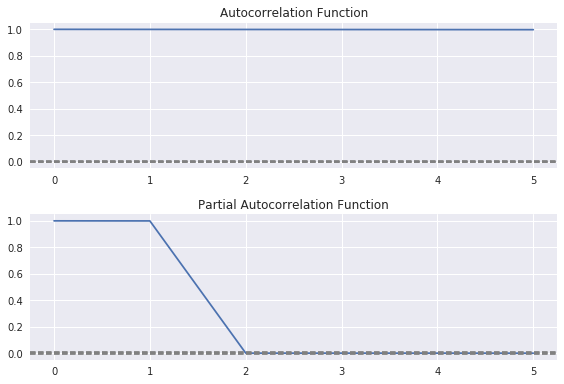

In [19]:
levels = np.array(map(lambda x: float(x), df_dataset['battery_level'][:100000]))
#levels_prep = np.divide(np.subtract(levels, np.mean(levels)), np.var(levels))
pacf = stattools.pacf(levels, nlags=5)
acf = stattools.acf(levels, nlags=5)

#%%
#Plot ACF (auto-correlation function)
plt.subplot(211) 
plt.plot(acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(levels)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(levels)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot Partial ACF (PACF)
plt.subplot(212)
plt.plot(pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(levels)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(levels)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

plt.show()

Clearly, the decay of ACF chart is very slow. Let’s see how ACF and PACF curve come out after regressing on the difference.

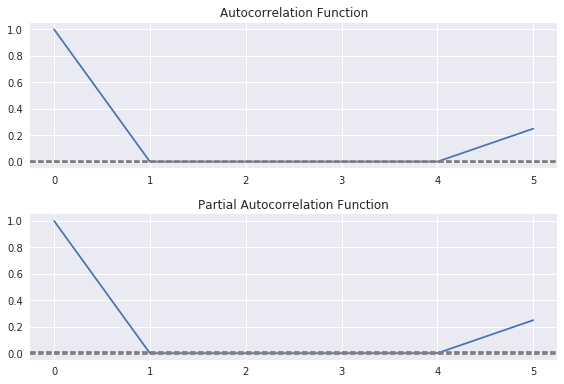

In [22]:
levels = np.array(map(lambda x: float(x), df_dataset['battery_level'][:100000]))
diff = levels[1:] - levels[:-1]
pacf = stattools.pacf(diff, nlags=5)
acf = stattools.acf(diff, nlags=5)

#%%
#Plot ACF (auto-correlation function)
plt.subplot(211) 
plt.plot(acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(levels)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(levels)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot Partial ACF (PACF)
plt.subplot(212)
plt.plot(pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(levels)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(levels)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

plt.show()

With all this information we now know how many lags we have to take into account for the prediction. That is, based on the charts showed above, we can say that the number of lags to be considered while predicting is just 1. So that's what we are going to do, we are going to add a new feature which is the previous state. 

In [18]:
df_dataset['prev_bat_level'] = np.append([None], df_dataset.loc[:, 'battery_level'].iloc[:-1])
df_dataset = df_dataset.dropna(0)

Despite the fact that we can use an ARMA model, it will be very limitted since we would only include past features, but not all the extra information that the smartphone's sensors trigger. We will use a Machine Learning algorithm instead, such as Linear Regression.

# Multivariate Analysis

Now it's time to go on to a more complex type of analysis, where we try get insights from the data as a whole, combining all the features. One of the most important tasks in multivariate analysis is to determine which are the most important features to estimate our target, in our case the battery level.

Let's start by carrying out an univariate feature selection. First of all, we will see what are the scores according to two different tests: *F-test* and *Mutual Information*. To further understand the difference between them see [this blog](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py).

In [19]:
from sklearn.feature_selection import f_regression, mutual_info_regression

features = "prev_bat_level min day battery_plugged conn conn_wifi bright_level screen_on sin cos cos_plugged".split()

print pd.Series(f_regression(df_dataset.loc[:, features], df_dataset['battery_level_smoothed'].astype(int))[0], index = features)
pd.Series(mutual_info_regression(df_dataset.loc[:100000, features], df_dataset['battery_level_smoothed'][:100000].astype(int)), index = features)

prev_bat_level     3.864703e+09
min                2.057714e+05
day                5.245782e+02
battery_plugged    1.284359e+05
conn               1.209343e+03
conn_wifi          2.852723e+03
bright_level       2.870248e+04
screen_on          3.227247e+04
sin                2.613632e+05
cos                6.395650e+03
cos_plugged        6.395650e+03
dtype: float64


prev_bat_level     3.995853
min                0.599339
day                0.067707
battery_plugged    0.193703
conn               0.028813
conn_wifi          0.024421
bright_level       0.002321
screen_on          0.059617
sin                0.308125
cos                0.244864
cos_plugged        0.244810
dtype: float64

We can see that clearly the most important feature is the previous battery level, but then there are some differences between the two methods. What they have in common is that the *day*, *conn*, *conn_wifi*, *screen_on* and *bright_level* is not greatly important when estimating the battery level. 

Let's now use a more inclusive and complex algorithm, we are going to build a regressor with different *Lasso* penalties and analyse the factors for each case.

In [31]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(df_dataset[features], df_dataset['battery_level'])
selected_features = pd.DataFrame([clf.coef_], columns=features, index=['0.1'])

clf = linear_model.Lasso(alpha=0.01)
clf.fit(df_dataset[features], df_dataset['battery_level'])
selected_features = selected_features.append(pd.Series(clf.coef_, index=features, name='0.01'))

clf = linear_model.Lasso(alpha=0.005)
clf.fit(df_dataset[features], df_dataset['battery_level'])
selected_features = selected_features.append(pd.Series(clf.coef_, index=features, name='0.005'))

clf = linear_model.Lasso(alpha=0.003)
clf.fit(df_dataset[features], df_dataset['battery_level'])
selected_features = selected_features.append(pd.Series(clf.coef_, index=features, name='0.003'))

clf = linear_model.Lasso(alpha=0.001)
clf.fit(df_dataset[features], df_dataset['battery_level'])
selected_features.append(pd.Series(clf.coef_, index=features, name='0.001'))

,prev_bat_level,min,day,battery_plugged,conn,conn_wifi,bright_level,screen_on,sin,cos,cos_plugged
0.1,0.999218,0.000004,-0.000000,0.000000,-0.000000,0.0,0.000263,-0.000000,0.000000,0.002665,0.0
0.01,0.996974,0.000073,-0.000488,0.414044,-0.000000,0.0,0.000306,-0.036509,0.000693,-0.000259,-0.0
0.005,0.996765,0.000081,-0.001836,0.444111,-0.000000,0.0,0.000272,-0.059351,0.000790,-0.000541,-0.0
0.003,0.996681,0.000084,-0.002375,0.456142,-0.000000,0.0,0.000259,-0.068488,0.000828,-0.000654,-0.0
0.001,0.996600,0.000088,-0.002893,0.467907,-0.002342,0.0,0.000245,-0.077667,0.000863,-0.000770,-0.0


We can see that an alpha value of 0.1 is very stringent, shrinking so many features to zero. However, with smaller alpha factors, the distribution of importances is quite similar, the top three features are: *prev_bat_level*, *battery_plugged*, and *screen_on*.

Combining all the methods we can leave out some features with a good confidence: *day*, *conn*, *conn_wifi*, *cos_plugged* and *bright_level*. Thus, the features to be considered for a Machine Learning algorithm should be: *prev_bat_level*, *min*, *battery_plugged*, *screen_on*, *sin* and *cos*.

# Testing

In [26]:
from sklearn.linear_model import LinearRegression

features = "prev_bat_level min battery_plugged screen_on sin cos cos_plugged".split()
target = "battery_level"

X = df_dataset[features][:-1]
y = np.asarray(df_dataset[target], dtype=int)[1:]

# We split the data before fitting the model
train_len = int(X.shape[0] * .35)
X_train = X[:train_len]
y_train = y[:train_len]
#X_test = X[150000:200000]
#y_test = y[150000:200000]
#X_train, X_test, y_train, y_test = cross_validation.\
#      train_test_split(X, y, test_size=0.3, random_state=0)
'''
# We sort the data before fitting the model
X_train['target'] = y_train
X_train = X_train.sort("relative_min")
y_train = np.array(X_train['target'])
X_train = X_train.drop('target', 1)
X_test['target'] = y_test
X_test = X_test.sort("relative_min")
y_test = np.array(X_test['target'])
X_test = X_test.drop('target', 1)
'''

#data, norms = normalize(X_train, return_norm=True, axis=0)
#norms = pd.Series(norms, index=features)
# Create linear regression object
# regr__ = linear_model.LinearRegression()
regr = LinearRegression()
# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import cross_validation

def predict_level(initial_pos=1, steps = 30, other_models = None):
    '''
    Once the model is fitted, this function returns the prediction for the
    minutes that are within the range initial_pos and initial_pos + steps.

    - initial_pos: initial position from which to start the prediction.
    - steps: number of rows to go ahead while doing the prediction.
    - other_models: this boolean variable indicates whether or not the 
    collaborating models should be used while carrying out the predictions.
    '''
    # We get the initial state
    initial_state = X[initial_pos:initial_pos+1]

    # Initial states both, for X and y
    state = initial_state.copy()
    predictions = [float(initial_state['prev_bat_level'])]
    states = pd.DataFrame(columns=state.columns)
    states = states.append(state, ignore_index=True)

    for i in range(1, steps):
        # We make a prediction, within the range [0:100]
        state_to_predict = pd.Series(index=state.columns)
        #for column in state.columns:
        #    state_to_predict[column] = float(state[column]) / self.__norms[column]
        prediction = max(min(float(regr.predict(state)[0]), 100), 0)
        predictions = predictions + [prediction]

        # We update the state for following predictions
        if other_models is not None:
            for key, value in other_models.iteritems():
                state[key] = 1 if value[0].predict(state[value[1]])[0] > value[2] else 0
        state['prev_bat_level'] = prediction

        #pos = i+initial_pos
        #state['relative_min'] += 1
        state['min'] = state['min'] + 1
        if (int(state['min']) >= 1440):
            state['min'] = 0
        #state['day'] = int(self.__X['day'][pos:pos+1])#+=+ 1
        amplitude = min(100 - battery_level_mean, battery_level_mean - 0)
        amplitude_plugged = min(1 - battery_plugged_mean, battery_plugged_mean - 0)
        state['sin'] = np.sin(np.pi * state['min'] / 1440) * amplitude + battery_level_mean
        state['cos'] = np.cos(np.pi * state['min'] / 1440) * amplitude + battery_plugged_mean
        #state['cos_plugged'] = np.cos(np.pi * state['min'] / 1440) * amplitude_plugged + battery_level_mean
        #state['prev1_plugged'] = state['bat_prev_1'] * state['battery_plugged']
        #state['bat_prev_1_square'] = np.square(state['bat_prev_1'])

        states = states.append(state, ignore_index=True)

    return (predictions, states)

def fit_other_models():
    '''
    This private function aims at fitting the collaborating models.
    '''
    other_models = dict()

    features = ["min", "screen_on"]
    target = "screen_on"
    screen_model = get_feature_model(features, target, DecisionTreeClassifier(), X, 1)
    other_models["screen_on"] = (screen_model, features[:], 0.5)

    features = ["min", "prev_bat_level", "cos_plugged"]
    target = "battery_plugged"
    plugged_model = get_feature_model(features, target, RandomForestClassifier(max_depth=3, n_estimators=10), X, 1)

    other_models['battery_plugged'] = (plugged_model, features[:], .9)
    
    return other_models



def get_feature_model(features, target, model, data_set, offset=0):
    '''
    Given certain features, a target column and the model that will be used
    to predict the target, this function returns the model fitted.

    Before fitting the model, it splits the data in train and test data 
    sets, and it also takes into account an offset in case the target
    feature is also in the features set. That is done when the the 
    prediction is based on the previous state.
    '''
    end = data_set.shape[0]
    X = pd.DataFrame(data_set[features][:end-offset], columns=features, dtype=float)
    y = np.asarray(data_set[target][offset:], dtype=int)

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, \
                                                test_size=0.3, random_state=0)

    model.fit(X_train, y_train)

    return model

In [65]:
other_models = fit_other_models()
print "fitted"


fitted


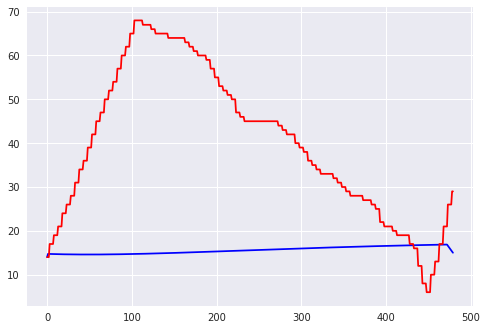

In [66]:
steps = 480
initial_pos=25785

plt.plot(range(steps), predict_level(initial_pos=initial_pos, steps=steps, other_models=other_models)[0], 'b',
         range(steps), y[initial_pos:initial_pos+steps], 'r')
plt.show()